# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

Нам нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Откроем датасет
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#Проверим, сколько дубликатов
df.duplicated().sum()

0

Как видим, дубликаты отсутствуют

In [5]:
#Выведем на экран первые 4 строк датасета
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


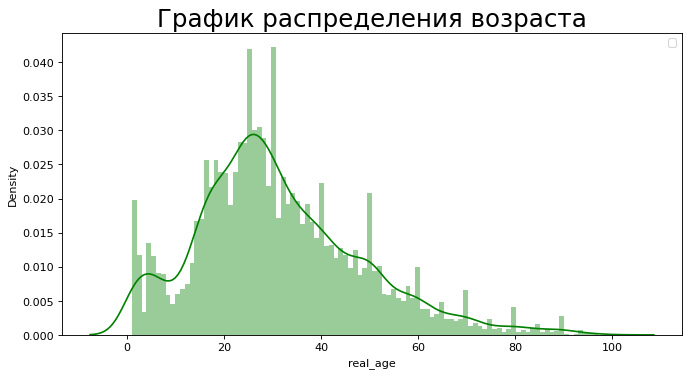

In [6]:
#Теперь построим график распределения возраста в выборке
plt.figure(figsize=(10, 5), dpi= 80)
sns.distplot((df['real_age']), color="g", bins=100)
plt.title('График распределения возраста', fontsize=22)
plt.legend()
plt.show()

По графику мы видим, что самый пик приходится на возраст 20-40 лет, а дальше: чем старше - тем меньше фотографий.

In [7]:
#Теперь загрузим файлы
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


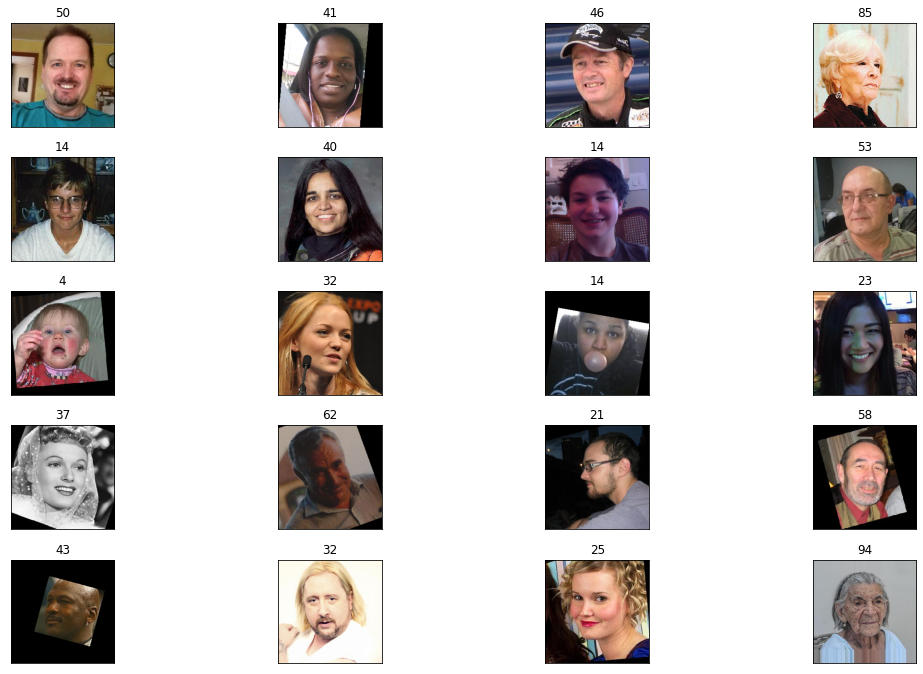

In [8]:
#Выгрузим 20 фотографий, чтобы посмотреть
x, y = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(20):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(y[i])
    plt.tight_layout()

Мы видим, что в датасете присутствуют портретные фото. Есть черно-белые, есть цветные. Ч/б фото меньше, чем цветных. Так же видим, что есть фото затемненные и с посторонними предметами на лице или около лица. Есть фото, где человек в очках и одно фото, так же имеются фото с полуанфас. Думаю, что эти факты не сильно повлияют на результат обучения модели.

## Обучение модели

```python

#Загрузим необходимые библиотеки
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0004)

#Загрузим обучающую выборку
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

#Загрузим тестовую выборку
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

#Создадим модель
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

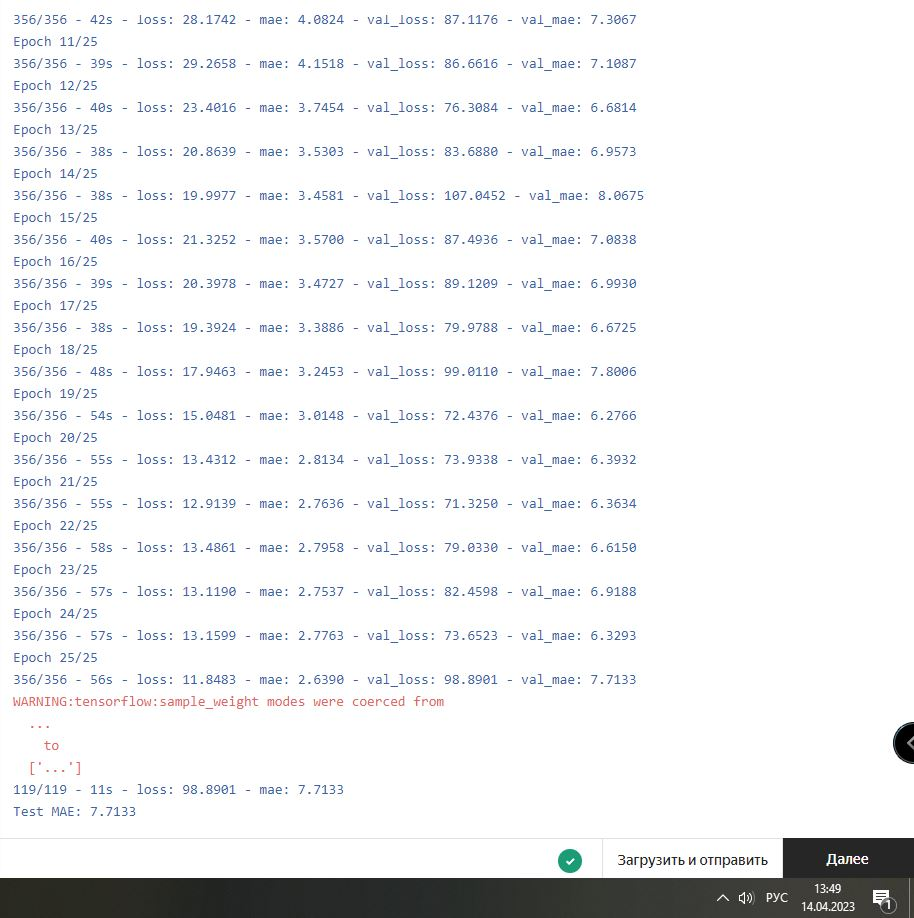

## Анализ обученной модели

При обучении нашей модели, мы использовали архитектуру ResNet50 c пулингом GlobalAveragePooling2D, слоем Dense с 1 нейроном и активацией relu, а так же скоростью обучения (learning_rate), равной 0.0004. Модель достигла значения MAE = 6.2766 на 19й из 25 эпох. Можно было бы использовать и меньше эпох, но тогда бы результат был на границе нужного значения.